# Comparing the Performance between *D* and *Python* Implementations for the Stochastic SIR CTMC model

In [9]:
import numba
from epistochmodels import SIR
from numpy.random import rand, gamma, exponential
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Python implementation
Here we present the equivalent Python implementation of the SIR model present in EpiStochModels

In [10]:
# numba.njit(cache=True)
def py_sir(N, tf, *pars):
    """
    Runs simulation.

    :parameters:
    :param N: tamanho da população
    :param tf: tempo final
    :param nsims:  Numero de simulações
    :param pars: parametros
    """
    beta, gam, I0 = pars
    
    t = [0]
    S = [N - I0]
    I = [I0]
    R = [N-(I[-1]+S[-1])]
    dts = []
    while I[-1] > 0 and t[-1] < tf:
        U = rand()
        # Probabilidade de que pelo menos um evento ocorra
        T = beta * S[-1] * I[-1] / N + gam * I[-1]
        # Probabilidade do próximo evento ser uma infecção
        pinf = ((beta / N) * S[-1] * I[-1]) / T

        if U <= pinf:  # próximo evento é uma infecçao
            dt = exponential(1 / T)

            S.append(S[-1] - 1)
            I.append(I[-1] + 1)
            R.append(R[-1])
            t.append(t[-1] + dt)
            dts.append(dt)
        else:  # próximo evento é uma recuperação
            S.append(S[-1])
            I.append(I[-1] - 1)
            R.append(R[-1] + 1)
            # print('removal')
            t.append(t[-1] + exponential(1 / T))  # -np.log(rand())/T)
    
    return (t, np.array([S,I,R]).T)

In [24]:
# Parameters
pop = 1_000_000
beta = 0.7
gamma = 0.3
tf = 1000
I0=10

In [12]:
%%timeit
res = py_sir(pop,tf, beta,gamma,I0)

5.99 s ± 58.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


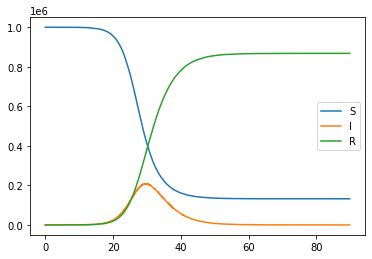

In [5]:
plot(res[0],res[1]);
legend(['S','I','R']);

## Timing the D implementation

In [6]:
model = SIR(pop,beta,gamma)
model.initialize(pop-I0,I0,0)

In [18]:
%%timeit
resD = model.run(0,tf)

897 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So the D version is $\frac{5.99}{0.89}=6.7$ times faster than the Python one. That does not seem much but D code is actually slowed down by the Python Wrapping. If you need more speed you can simulate the model in pure D for a more substantial speed up (15.3x).

In [25]:
!dub run --build=release --compiler=ldc2 --single sir_example.d

Performing "release" build using ldc2 for x86_64.
mir-core 1.0.3: target for configuration "library" is up to date.
mir-algorithm 3.5.7: target for configuration "default" is up to date.
mir-random 2.2.15: target for configuration "extended" is up to date.
pyd 0.14.0: target for configuration "python38" is up to date.
epistochmodels ~master: target for configuration "library" is up to date.
sir_example ~master: building configuration "application"...
Linking...
To force a rebuild of up-to-date targets, run again with --force.
Running ./sir_example 
Time of the SIR run with N=1000000: 398 ms, 459 μs, and 4 hnsecs
Number of steps: 1737769


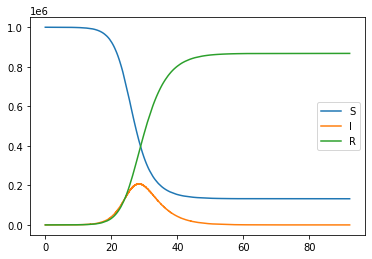

In [12]:
plot(resD[0],resD[1]);
legend(['S','I','R']);